## 패키지 불러오기 및 주요 변수 설정하기

In [1]:
# 한글 폰트(나눔) 설치하기, 런타임 재시작 할 것
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 22 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (6,725 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 128215 files and di

In [1]:
!pip install pykrx -q
!pip install finance-datareader -q
!pip install yfinance -q
!pip install git+https://github.com/quantopian/pyfolio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.5/125.5 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 KB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

from math import sqrt
from scipy import stats, optimize 
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

from pykrx import stock
from pykrx import bond
import FinanceDataReader as fdr
import pandas_datareader.data as pdr
import yfinance as yf
yf.pdr_override()

import time
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', '{:.4f}'.format)
plt.rc('font', family='NanumBarunGothic')

## 데이터 가져오기

In [3]:
asset_ls = ['korea', 'US', 'euro', 'japan', 'china']

In [4]:
start_date, end_date = "2012-12-28",  "2023-01-31"

korea = pdr.get_data_yahoo("^KS11", start_date, end_date)['Adj Close']
US = pdr.get_data_yahoo("^GSPC", start_date, end_date)['Adj Close']
euro = pdr.get_data_yahoo("^STOXX50E", start_date, end_date)['Adj Close']
japan = pdr.get_data_yahoo("^N225", start_date, end_date)['Adj Close']
china = pdr.get_data_yahoo("399001.SZ", start_date, end_date)['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
# 성과 평가를 위해 수익률 기록
ticker_list = [korea, US, euro, japan, china]
returns = {}
for idx, ticker in enumerate(ticker_list):
  returns[idx] = ticker.pct_change().dropna()
returns = pd.DataFrame(returns)
returns.columns = asset_ls
returns = returns[returns.index >= "2013-01-01"].fillna(0)

## 리스크 패리티

### 셋업

In [6]:
# 비중행렬(각 주식의 기대수익, 최소비중, 최대비중, SAA 비중 포함)
weight_constraint = pd.DataFrame([[0 for _ in range(len(asset_ls))],
                        [100 for _ in range(len(asset_ls))],
                       [100/len(asset_ls) for _ in range(len(asset_ls))]],
          columns= asset_ls,
          index=['최소비중', '최대비중', '초기 비중'])/100
weight_constraint

,korea,US,euro,japan,china
최소비중,0.0000,0.0000,0.0000,0.0000,0.0000
최대비중,1.0000,1.0000,1.0000,1.0000,1.0000
초기 비중,0.2000,0.2000,0.2000,0.2000,0.2000


In [7]:
# 연율화 시킴
def EWMA_covariance(df, lam=0.97, de_mean=True, annualize=True):
  tickers = df.columns
  N = df.shape[0]
  weight_sum = sum([lam ** (N-i-1) for i in range(N)])
  n_assets = df.shape[1]
  ewma_cov = [[0 for _ in range(n_assets)] for _ in range(n_assets)]

  if de_mean:
    ert = df.mean()
    mat = df.sub(ert)
  else:
    mat = df
  for i in range(n_assets):
    for j in range(n_assets):
      ewma_cov[i][j] = sum([mat.iloc[k, i] * mat.iloc[k, j] * (lam ** (N-k-1)) for k in range(N)]) / weight_sum
  ewma_cov = pd.DataFrame(ewma_cov, columns = tickers, index = tickers)

  if annualize:
    ewma_cov = ewma_cov * 252

  return ewma_cov

In [8]:
# 각 자산의 위험기여도를 출력하는 함수
# 각 자산의 비중과 공분산 행렬을 가지고, 각 자산에 대한 위험 기여도 산출 가능
def calculate_risk_contribution(weight, cov):
  variance = np.array(weight).T @ cov @ np.array(weight)
  sigma = sqrt(variance)
  mrc = 1/sigma * (cov @ weight)
  risk_contribution = weight * mrc
  risk_contirbution = risk_contribution/ risk_contribution.sum()
  return risk_contirbution

In [9]:
# 리스크 패리티의 목적함수
# 만약 의도한 대로 위험기여도가 모두 같다면 목적함수의 값은 0이 된다.
def risk_parity_for_optimization(weight):
  global covariance_matrix
  risk_contribution = calculate_risk_contribution(weight, covariance_matrix)
  sum_risk_diffs_squared = 0
  for i in range(len(risk_contribution)):
      sum_risk_diffs_squared += np.square(risk_contribution[i] - 1/len(risk_contribution))
  return sum_risk_diffs_squared

In [10]:
# 시작점과 비중의 상하한선을 설정(비중 상하한선에 내에서 나오지 않으면 최적화는 실패)
Init_Point = tuple(weight_constraint.loc['초기 비중',:])
bnds = tuple([(min_weight, max_weight) for (min_weight,max_weight) in zip(weight_constraint.loc['최소비중', :], weight_constraint.loc['최대비중', :])])

# 제약조건은 오직 자산의 비중 합이 1이라는 것 하나 뿐
def weight_sum_optimization(weights):
  return sum(weights)-1

In [11]:
# 위와 마찬가지로 비중합이 1
RP_constraint = [{'type': 'eq', 'fun': weight_sum_optimization}]
options = {'ftol': 1e-20, 'maxiter': 50000}

### 리스크 최적화 포트폴리오

In [12]:
# 2014년 1분기~ 2022년 4분기까지 분기마다 리밸런싱을 실시(그 때마다 비중을 다시 조정)
# 이 때 공분산 행렬은 지난 1년의 일별수익률의 지수가중공분산을 연율화한 것을 사용

# 리밸런스할 날짜 구하기
rebalance_date = []
for year in range(2014, 2023):
  for month in range(1, 13, 3):
    day = 1
    while True:
      idx = "-".join([str(year), str(month).zfill(2), str(day).zfill(2)])
      if idx in returns.index:
        rebalance_date.append(idx)
        break
      day += 1

In [13]:
risk_parity_weights = pd.DataFrame()
for date in rebalance_date:
  start_date = "-".join([str(int(date.split("-")[0])-1), date.split("-")[1], "01"])
  end_date = date
  temp_return = returns[(start_date <= returns.index) & (returns.index < end_date)]
  global covariance_matrix
  covariance_matrix = EWMA_covariance(temp_return)
  risk_parity_portfolio = optimize.minimize(risk_parity_for_optimization, Init_Point, method='SLSQP', bounds=bnds, constraints=RP_constraint, options=options).x
  risk_parity_portfolio = pd.DataFrame(risk_parity_portfolio).T
  risk_parity_portfolio.columns = asset_ls
  risk_parity_portfolio.index = [date]
  risk_parity_weights = pd.concat([risk_parity_weights, risk_parity_portfolio], axis=0)
risk_parity_weights.index = pd.to_datetime(risk_parity_weights.index)
risk_parity_weights = risk_parity_weights.resample("D").last().fillna(method='ffill')
risk_parity_weights.head()

,korea,US,euro,japan,china
2014-01-02,0.2290,0.2837,0.1925,0.1276,0.1672
2014-01-03,0.2290,0.2837,0.1925,0.1276,0.1672
2014-01-04,0.2290,0.2837,0.1925,0.1276,0.1672
2014-01-05,0.2290,0.2837,0.1925,0.1276,0.1672
2014-01-06,0.2290,0.2837,0.1925,0.1276,0.1672


In [14]:
test_returns = returns[(returns.index >= rebalance_date[0]) & (returns.index < "2023-01-01")]
daily_return = test_returns * risk_parity_weights
daily_return = daily_return.dropna().sum(axis=1).to_frame("daily_return")
daily_return

,daily_return
2014-01-02,-0.0077
2014-01-03,-0.0060
2014-01-06,-0.0076
2014-01-07,0.0041
2014-01-08,0.0023
...,...
2022-09-27,0.0050
2022-09-28,-0.0104
2022-09-29,-0.0039
2022-09-30,-0.0092


In [15]:
cumulative_return = np.exp(np.log(daily_return['daily_return'] + 1).cumsum())-1
cumulative_return = cumulative_return.to_frame("cumulative return")
cumulative_return

,cumulative return
2014-01-02,-0.0077
2014-01-03,-0.0136
2014-01-06,-0.0211
2014-01-07,-0.0171
2014-01-08,-0.0149
...,...
2022-09-27,0.5489
2022-09-28,0.5328
2022-09-29,0.5269
2022-09-30,0.5129


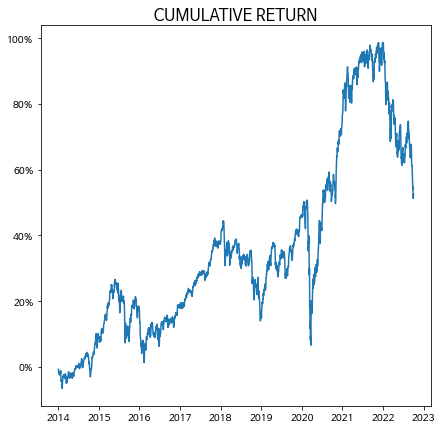

In [16]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.plot(cumulative_return)
ax.set_title("CUMULATIVE RETURN", fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

### 벤치마크 제작

In [17]:
daily_benchmark_return = test_returns * np.array([1/len(asset_ls) for _ in range(len(asset_ls))])
daily_benchmark_return = daily_benchmark_return.dropna().sum(axis=1).to_frame("daily_benchmark_return")
daily_benchmark_return

,daily_benchmark_return
Date,
2014-01-02,-0.0063
2014-01-03,-0.0060
2014-01-06,-0.0100
2014-01-07,0.0031
2014-01-08,0.0037
...,...
2022-12-26,0.0040
2022-12-27,0.0040
2022-12-28,-0.0107


In [18]:
benchmark_cumulative_return = np.exp(np.log(daily_return['daily_return'] + 1).cumsum())-1
benchmark_cumulative_return = benchmark_cumulative_return.to_frame("benchmark_cumulative_return")
benchmark_cumulative_return

,benchmark_cumulative_return
2014-01-02,-0.0077
2014-01-03,-0.0136
2014-01-06,-0.0211
2014-01-07,-0.0171
2014-01-08,-0.0149
...,...
2022-09-27,0.5489
2022-09-28,0.5328
2022-09-29,0.5269
2022-09-30,0.5129


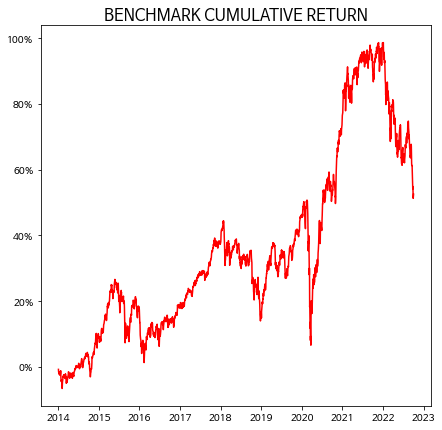

In [19]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.plot(benchmark_cumulative_return, color='red')
ax.set_title("BENCHMARK CUMULATIVE RETURN", fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

### 파이폴리오 성과

In [20]:
import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

Text(0.5, 1.0, 'Rolling Sharpe Ratio (3 Months)')

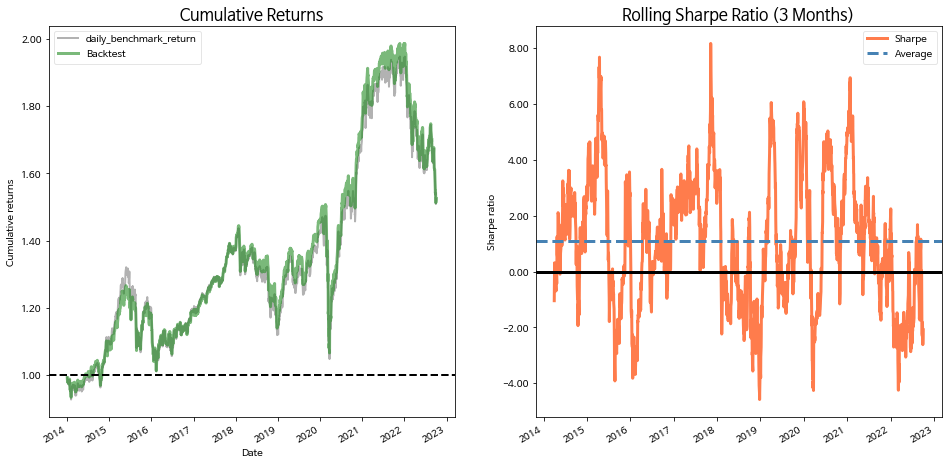

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

plot_rolling_returns(daily_return['daily_return'],
                     factor_returns=daily_benchmark_return['daily_benchmark_return'],
                     logy=False,
                     legend_loc='best',
                     volatility_match=False,
                    ax=axes[0])
plot_rolling_sharpe(daily_return['daily_return'], ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns', fontsize=16)
axes[1].set_title('Rolling Sharpe Ratio (3 Months)', fontsize=16)

Start date,2014-01-02
End date,2022-10-03
Total months,108
,Backtest
Annual return,4.786%
Cumulative returns,52.561%
Annual volatility,12.374%
Sharpe ratio,0.44
Calmar ratio,0.16
Stability,0.83
Max drawdown,-29.296%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,29.30,2020-02-17,2020-03-23,2020-07-09,104
1,23.86,2022-01-04,2022-09-30,NaT,NaN
2,21.11,2018-01-26,2018-12-25,2019-12-16,492
3,19.99,2015-05-25,2016-02-12,2017-06-02,530
4,7.13,2014-09-19,2014-10-16,2014-11-18,43


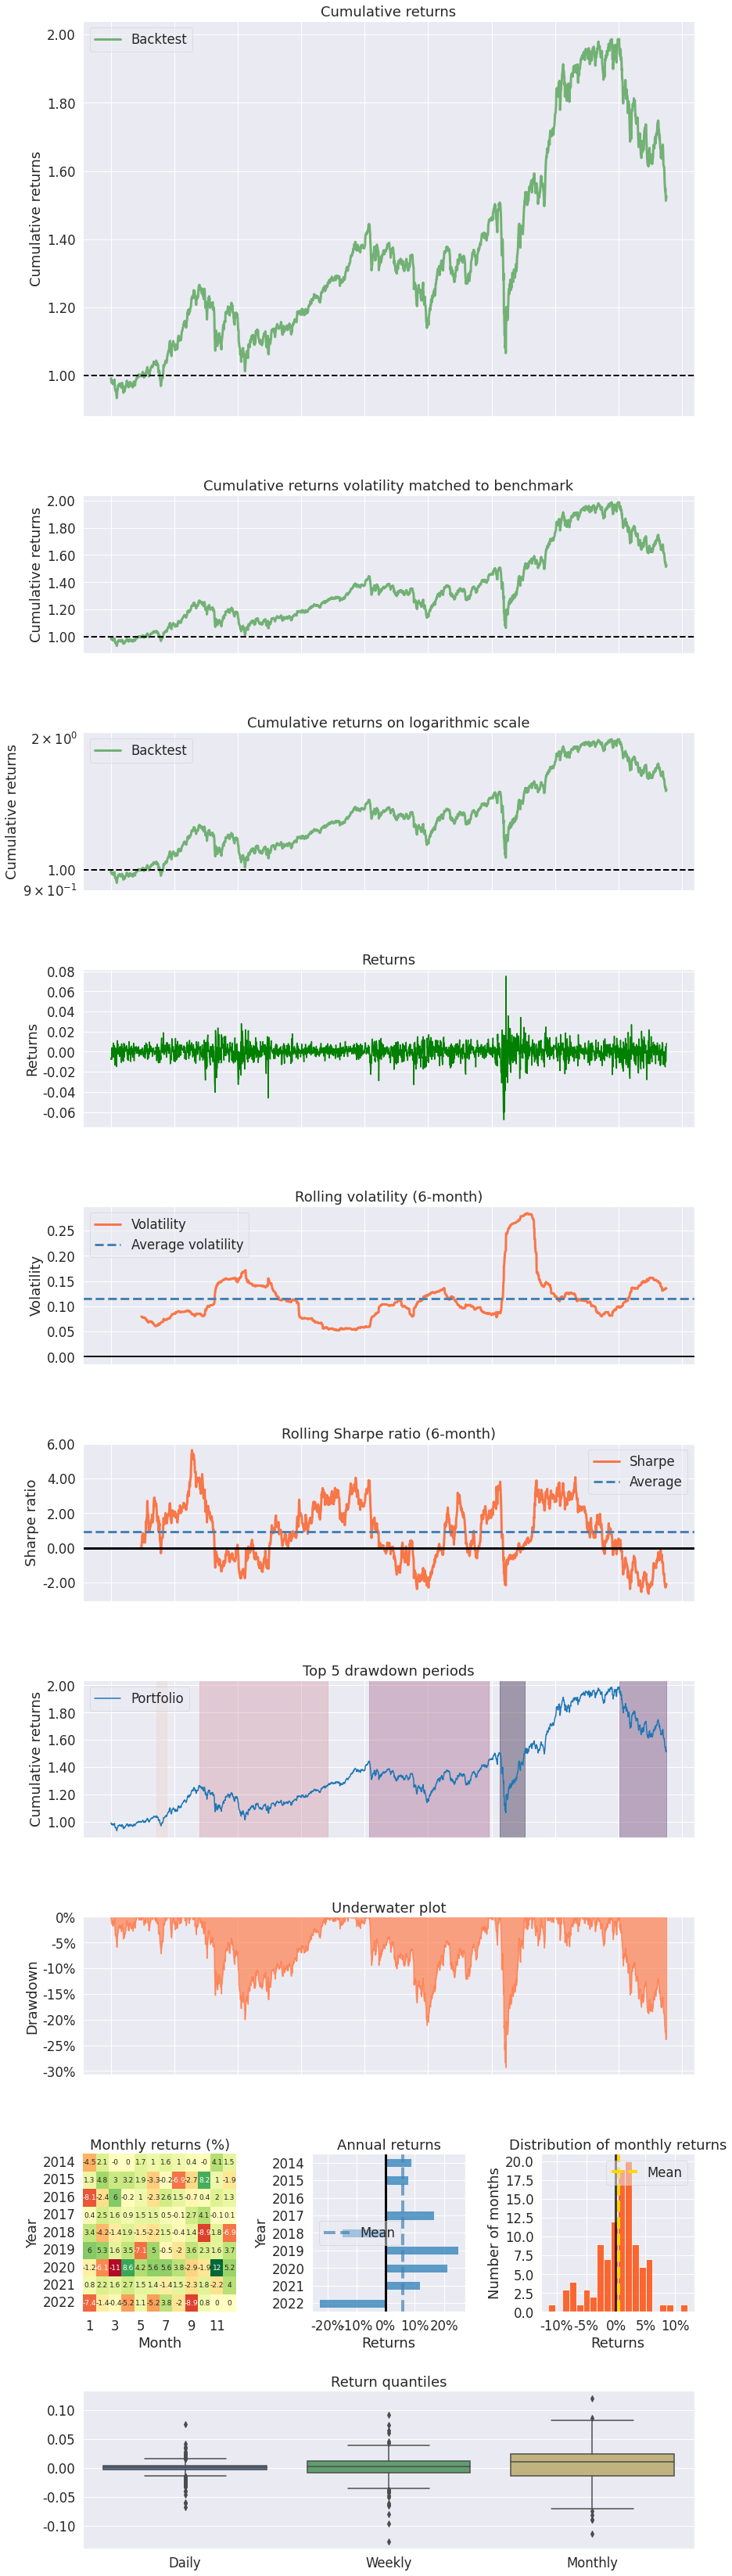

In [22]:
pf.create_returns_tear_sheet(daily_return['daily_return'])

Start date,2014-01-02
End date,2022-12-30
Total months,111
,Backtest
Annual return,5.167%
Cumulative returns,59.681%
Annual volatility,12.926%
Sharpe ratio,0.45
Calmar ratio,0.18
Stability,0.79
Max drawdown,-28.933%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.93,2020-02-17,2020-03-23,2020-07-13,106
1,23.46,2015-05-27,2016-02-12,2017-09-29,613
2,22.53,2021-11-22,2022-09-30,NaT,NaN
3,22.07,2018-01-23,2018-12-25,2020-01-09,513
4,7.04,2014-09-19,2014-10-16,2014-11-11,38


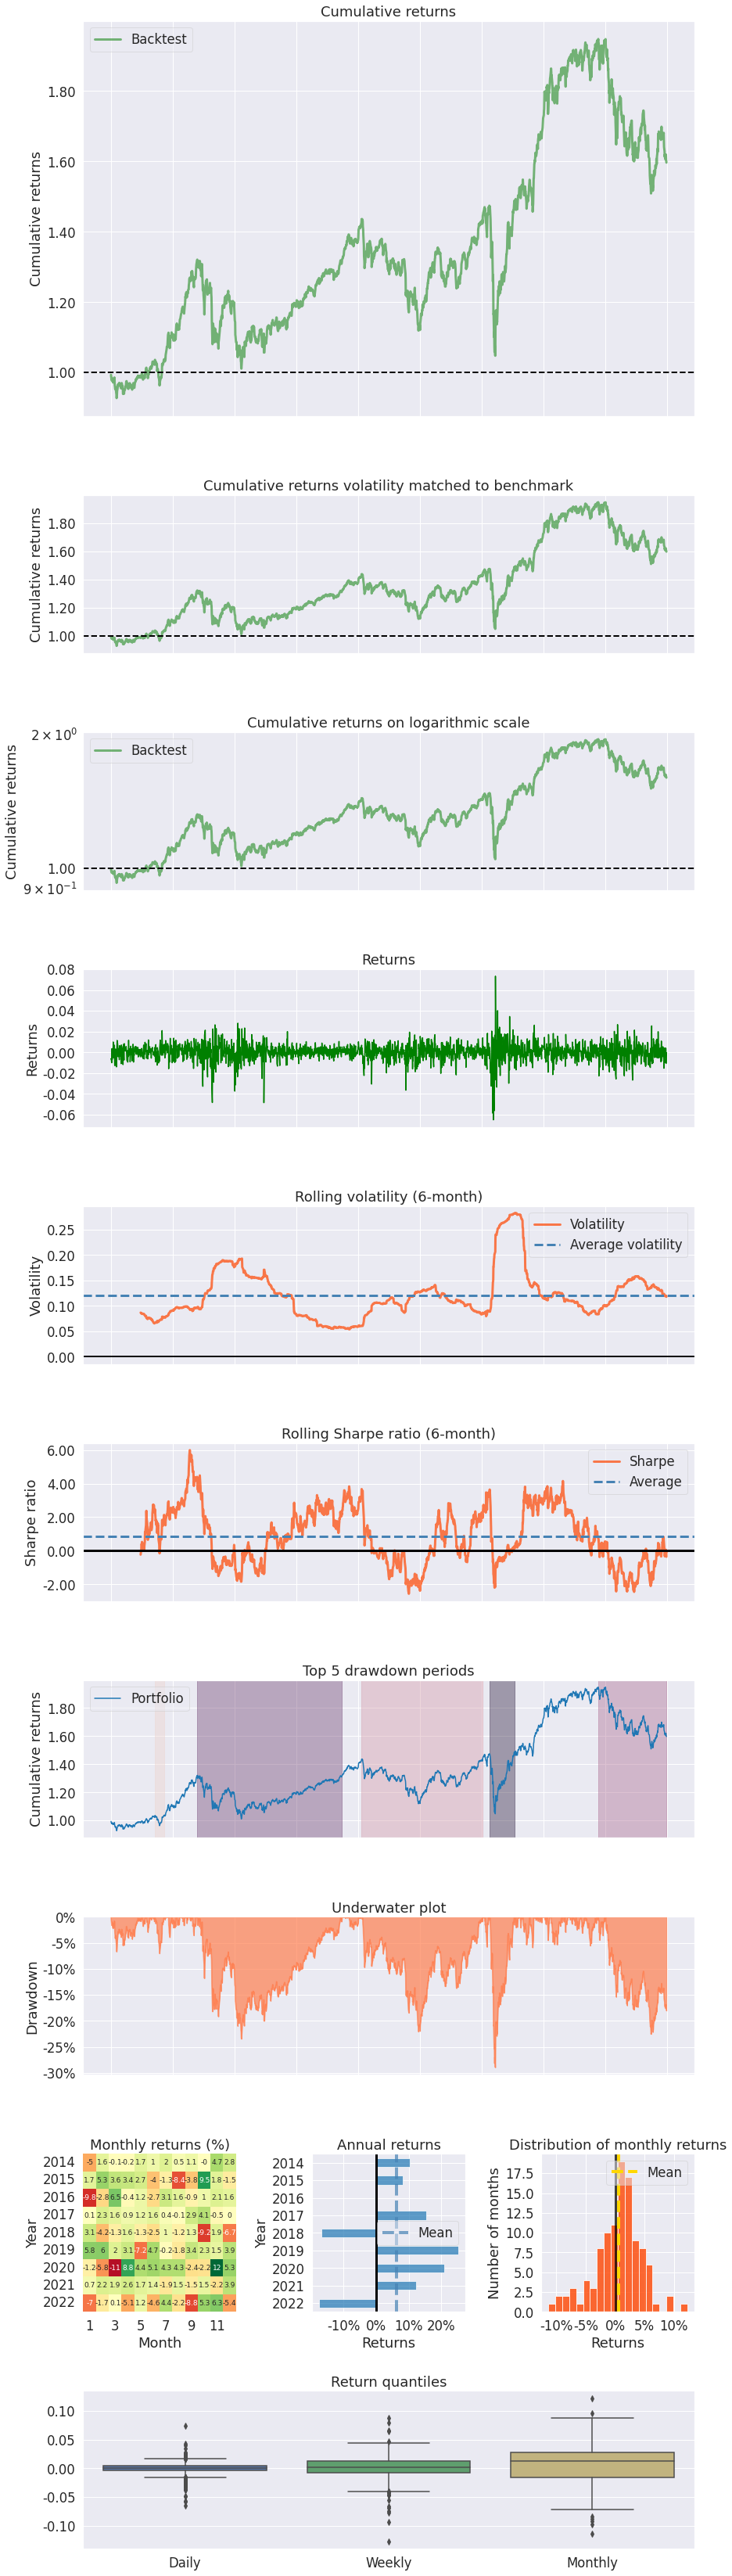

In [23]:
pf.create_returns_tear_sheet(daily_benchmark_return['daily_benchmark_return'])